[*********************100%***********************]  1 of 1 completed


The probability of dropping over 10% in one month(22days) is  0.08967817915451776
With 5% chance, the daily return is worse than %(or may win/loss %): -5.057323873815398
stock_code:NVDA
initial price: Ticker
NVDA    138.630005
Name: 2024-12-02 00:00:00+00:00, dtype: float64 
Average Price: 152.80400084526863 
Standard Deviation: 19.59861527258741 
95% confidence interval: 191.21728677953996 - 114.3907149109973 
68% confidence interval: 172.40261611785604 - 133.20538557268122 
Sharp: Ticker
NVDA    2.144685
dtype: float64 
initial_cdf: [0.23477416]; initial_pdf: [0.30713807] 
Max: 223.2840872507244; min: 98.24156825112651


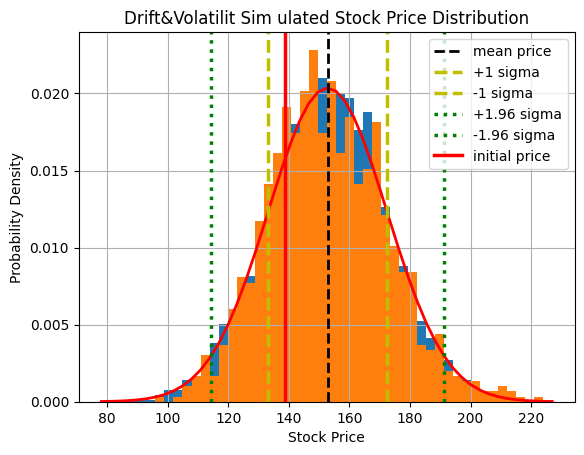

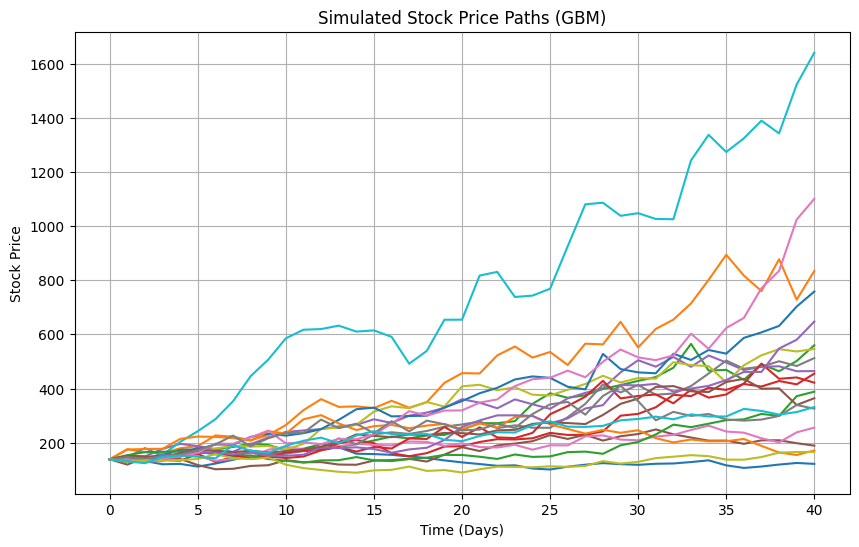

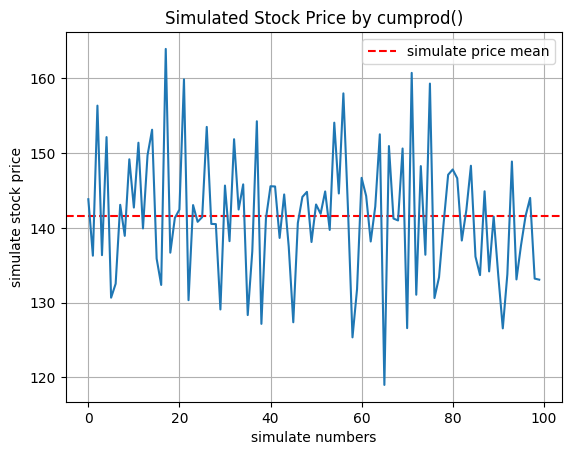

In [11]:
#設定： 股票代碼，歷史資料，模擬時間長度，模擬次數，安裝模組
from datetime import date, datetime # Import the datetime module
import datetime
import yfinance as yf
import numpy as np
import math
import pandas as pd
stock_code = "NVDA" # @param {type:"string"}
start_date = "2024-01-01" # @param {type:"date"}
#end_date = '2024-09-20'
interval = "1D" # @param ["1D", "1WK", "1MO"]
days = 40 # @param {"type":"number"} # days是設定模擬未來股價的天數
## 以NVDA為例，同一段時間日期影響mu，sigma的因素是"days"，day取值越大，mu會越大，估計值會失真！建議取22～63天為適當。
simulate_number = 1000 # @param {type:"number"}
time_horizon = 1 # @param {type:"number"}  # Simulation horizon in years
confidence_level = 0.95 #@param ["0.99", "0.95", "0.68"]
end_date = datetime.date.today()

#download data
df = yf.download(stock_code, start= start_date, end= end_date, interval=interval)
#print(df
# Rest of the code remains the same, initial = df['Adj Close'].iloc[-1]
initial = df['Adj Close'].iloc[-1]
#計算Daily Volatility, returns = df['Adj Close'].pct_change().dropna()
returns = df['Adj Close'].pct_change().dropna()
Daily_Volatility = returns.std()
#計算Daily Drift= np.log (1+ df['Adj Close'].pct_change().dropna())
Drift = np.log (1+ df['Adj Close'].pct_change().dropna())
Daily_Drift_mean = Drift.mean()
#計算Annual Volatility = Daily_Volatility * math.sqrt(252)
Annual_Drift = Daily_Drift_mean * 252
Annual_Volatility = Daily_Volatility * math.sqrt(252)
#計算Drift Mean = Daily_Drift_mean - 0.5 * (Daily_Volatility)**2
Drift_Mean = Daily_Drift_mean - 0.5 * (Daily_Volatility)**2
#計算Return- mu, sigma = returns.mean()*252, returns.std()*np.sqrt(252)
mu_ret, sigma_ret = returns.mean(), returns.std()
ann_mu_ret, ann_sigma_ret = returns.mean()*252, returns.std()*np.sqrt(252)

# Convert potential Series objects to numerical values before formatting
Daily_Volatility_val = Daily_Volatility.iloc[-1] if isinstance(Daily_Volatility, pd.Series) else Daily_Volatility
mu_ret_val = mu_ret.iloc[-1] if isinstance(mu_ret, pd.Series) else mu_ret
sigma_ret_val = sigma_ret.iloc[-1] if isinstance(sigma_ret, pd.Series) else sigma_ret
Drift_Mean_val = Drift_Mean.iloc[-1] if isinstance(Drift_Mean, pd.Series) else Drift_Mean
ann_mu_ret_val = ann_mu_ret.iloc[-1] if isinstance(ann_mu_ret, pd.Series) else ann_mu_ret
ann_sigma_ret_val = ann_sigma_ret.iloc[-1] if isinstance(ann_sigma_ret, pd.Series) else ann_sigma_ret

## 依據Excel計算days天的股價平均值，並模擬simulate_number次數後的每次平均值做股價資訊的統計，畫出分佈圖及GBM股價預測圖，
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#依照Excel的預測模型及公式，使用python計算主要參數，並依據模擬天數及模擬次數來預測未來股價的平均值與標準差
ssps = [days]
results =[]
for i in range(simulate_number):
    z = np.random.standard_normal(size=days) #計算 Z~N(0,1)@95% confidence interval， 需要再研究探討
    ln_return = Drift_Mean_val + Daily_Volatility_val * z #計算ln(return)
    ssp = initial
    for x in ln_return:
        ssp = ssp * np.exp(x) # 估算股價 ssp(simulate stock price)
        ssps.append(ssp)      # 計算126筆預測股價SSP後，append到SSPS成為一個序列（list）
    result = np.mean(ssps[1:])  # 計算ssps(simulate stock price) 的平均值"results"
    results.append(result)  # 把result平均值紀錄在results 序列內（list）
    ssps = []               # 跑完一次模擬（simulate_number）的'days'筆後，需要清空，在進行下一筆模擬，直到完成所有（simulate_number）的模擬次數為止
results_array = np.array(results) # 將results序列內的平均值記錄在results_ndarray中

# 從(mu, sigma)分佈，抽樣並畫出抽樣分佈
mu_price = results_array.mean()
sigma_price = results_array.std()
Max = results_array.max()
min = results_array.min()
S = np.random.normal(mu_price, sigma_price, 10000)
count, bins, ignored = plt.hist(S, 50, density=True, stacked=True)
def plot_normal_distribution(mu, sigma):
    x = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 100)
    #plt.plot(x, norm.pdf(x, mu, sigma))
    #plt.xlabel('Stock Price')
    #plt.ylabel('Probability Density')
    #plt.title('Normal Distribution')
    # Access the initial price as a single value (scalar)
    initial_price = initial.iloc[-1] if isinstance(initial, pd.Series) else initial
    plt.axvline(x=mu, color='black', linestyle='dashed', linewidth=2, label='mean price')
    # Calculated 95% Confidence Interval
    U_95 = mu_price + 1.96 * sigma_price
    L_95 = mu_price - 1.96 * sigma_price
    # Calculated 68% Confidence Interval
    U_68 = mu_price + 1 * sigma_price
    L_68 = mu_price - 1 * sigma_price

    # Plot the vertical lines
    plt.axvline(x=U_68, color='y', linestyle='dashed', linewidth=2.5, label='+1 sigma')
    plt.axvline(x=L_68, color='y', linestyle='dashed', linewidth=2.5, label='-1 sigma')
    plt.axvline(x=U_95, color='g', linestyle='dotted', linewidth=2.5, label='+1.96 sigma')
    plt.axvline(x=L_95, color='g', linestyle='dotted', linewidth=2.5, label='-1.96 sigma')

    plt.grid(True)
    plt.legend()
    return U_95, U_68, L_95, L_68

# 计算initial的pdf(probility density function)
# Create a function to calculate the PDF of the normal distribution
def normal_pdf(w):
  # Use the scipy.stats.norm module to calculate the PDF
  y = (w - mu_price) / sigma_price
  return norm.pdf(y, loc=0, scale=1)

# Calculate the PDF for a range of values
cdf_values = norm.cdf(initial, mu_price, sigma_price)
pdf_values = normal_pdf(initial)

# Calculated 95% Confidence Interval
U_95 = mu_price + 1.96 * sigma_price
L_95 = mu_price - 1.96 * sigma_price
# Calculated 68% Confidence Interval
U_68 = mu_price + 1 * sigma_price
L_68 = mu_price - 1 * sigma_price
# calculate Sharp
Sharp = Annual_Drift / Annual_Volatility

# Access the initial price as a single value (scalar)
initial_price = initial.iloc[-1] if isinstance(initial, pd.Series) else initial

# drop over 10% in 22 days
mu22 = 22 * mu_ret_val #daily return * 22
sigma22 = (22**0.5) * sigma_ret_val # daily sigma*sqrt(22)
drop10 = norm.cdf(-0.1, mu22, sigma22)
print('The probability of dropping over 10% in one month(22days) is ', drop10)

#Calculate Value at risk (VaR)
# Value at risk(VaR)
# with 5% chance, the daily return is worse than (-VaR) value
VaR = norm.ppf(0.05, mu_ret_val, sigma_ret_val)
print('With 5% chance, the daily return is worse than %(or may win/loss %):', np.multiply(VaR, 100))

#列印主要參數
print(f"stock_code:{stock_code}\ninitial price: {initial} \nAverage Price: {mu_price} \nStandard Deviation: {sigma_price} \n95% confidence interval: {U_95} - {L_95} \n68% confidence interval: {U_68} - {L_68} \nSharp: {Sharp} \ninitial_cdf: {cdf_values}; initial_pdf: {pdf_values} \nMax: {Max}; min: {min}")
#plt.figure(figsize=(10,8))
plt.plot(bins, 1/(sigma_price * np.sqrt(2 * np.pi)) * np.exp(-(bins - mu_price)**2 / (2 * sigma_price**2)), linewidth = 2, color = 'r')
plt.hist(results_array,bins, density=True, stacked=True)
plot_normal_distribution(mu_price, sigma_price) # call plot_normal_distribution function
plt.xlabel('Stock Price')
plt.ylabel('Probability Density')
plt.xlabel("Stock Price")
plt.title("Drift&Volatilit Sim ulated Stock Price Distribution")
plt.axvline(x=initial_price, color='r', linestyle='solid', linewidth=2.5, label='initial price') #設定垂直(axv)軸線型態
plt.legend()
plt.grid(True)
plt.show()

#===============================================================================================
# GBM mode simulate stock price
# Python code example using the Geometric Brownian Motion (GBM) model for a Monte Carlo simulation of stock prices
def simulate_stock_price(initial, Annual_Driftrift, Annual_Volatility, time_horizon, simulate_number):
  """
  Simulates stock price paths using the Geometric Brownian Motion model.

  Args:
      initial_price: The initial price of the stock.
      drift: The average return of the stock (annualized).
      volatility: The volatility of the stock (annualized standard deviation).
      time_horizon: The simulation time horizon in years.
      num_simulations: The number of simulations to run.

  Returns:
      A NumPy array of shape (num_simulations, time_steps) containing the simulated price paths.
  """
  dt = time_horizon / days  # Time step (assuming daily data)
  time_steps = int(time_horizon * days) + 1  # Number of time steps + 1 (initial price)

  # Simulate random normal deviates for each path
  random_normals = np.random.normal(0, np.sqrt(dt), size=(simulate_number, time_steps))

  # Convert potential Series objects to numerical values before formatting
  Annual_Drift_val = Annual_Drift.iloc[-1] if isinstance(Annual_Drift, pd.Series) else Annual_Drift
  Annual_Volatility_val = Annual_Volatility.iloc[-1] if isinstance(Annual_Volatility, pd.Series) else Annual_Volatility
  initial_val = initial.iloc[-1] if isinstance(initial, pd.Series) else initial
  time_horizon = time_horizon.iloc[-1] if isinstance(time_horizon, pd.Series) else time_horizon
  simulate_number = simulate_number.iloc[-1] if isinstance(simulate_number, pd.Series) else simulate_number

  # Calculate price changes by model of (drift + volatility * random_normal)
  price_changes = (Annual_Drift_val - 0.5 * Annual_Volatility_val**2) * dt + Annual_Volatility_val * random_normals

  # Initialize stock price paths
  stock_prices = np.zeros((simulate_number, time_steps))
  stock_prices[:, 0] = initial_val

  # Update stock prices for each time step
  for i in range(1, time_steps):
    stock_prices[:, i] = stock_prices[:, i-1] * np.exp(price_changes[:, i])

  return stock_prices


simulated_prices = simulate_stock_price(initial, Annual_Drift, Annual_Volatility, time_horizon, simulate_number)

# Convert the NumPy array to a pandas DataFrame for sampling
simulated_prices_df = pd.DataFrame(simulated_prices)

# Plot some simulated price paths
plt.figure(figsize=(10, 6))
df_samples = simulated_prices_df.sample(n=20, random_state=42) # 30 random rows, with a fixed seed for reproducibility
for j in range(20):  # Plot a sample of 20 simulations
  plt.plot(df_samples.iloc[j, :])
plt.xlabel("Time (Days)")
plt.ylabel("Stock Price")
plt.title("Simulated Stock Price Paths (GBM)")
plt.grid(True)
plt.show()
#print('GBM Avg Price:', simulated_prices.mean())
# Analyze simulated price distribution (optional)
# You can calculate statistics like average ending price, standard deviation, etc.
#===============================================================================================
# predict stock price by input days & simulation number
# use cumprod() function for simulating future stock prices because it efficiently calculates the product of all previous changes, including both positive and negative ones
sim_prices_append_after_d_days = []
n = 100
d = 10
# Access initial as a scalar value
initial_price = initial.iloc[-1] if isinstance(initial, pd.Series) else initial

for i in range(1, n+1):
    sim_rets = np.random.normal(mu_ret,sigma_ret,d)
    # Use initial_price (scalar) for multiplication
    sim_prices_after_d_days = initial_price * (sim_rets +1).cumprod()
    sim_prices_append_after_d_days.append(sim_prices_after_d_days.mean())
plt.axhline(np.mean(sim_prices_append_after_d_days), color='r', linestyle='dashed', label='simulate price mean')
plt.legend()
plt.plot(sim_prices_append_after_d_days)
plt.xlabel('simulate numbers')
plt.ylabel('simulate stock price')
plt.title("Simulated Stock Price by cumprod()")
plt.grid(True)
plt.show()